# User EDA

### Driving Question
We have not yet been able to do an over-arching analysis on all of the users that have contributed their data. Hence, we want to do some EDA to see which users will be most useful in our various analyses and visualisations that will make up the product notebook.

### Importing the Data



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
def read_CLEAN_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Convert datetimes
    dat["Date"] = pd.to_datetime(dat["Date"], format = '%Y-%m-%d').dt.date
    
    return dat

We use the *pre-cleaned* data from the worksheet `reading/DataCleaning_`, which means we don't have to preprocess everything again. We create an array of data sets and an array of the names of each of the files so that we can identify each of the datasets.

In [3]:
filenames = []
dfs = []

FILEPATH = "../../data/cleaned"
for file in os.scandir(FILEPATH):
    filenames.append(file.path)
    dfs.append(read_CLEAN_data(file.path))

### Introductory EDA

We want to calculate some basic statistics for each dataset, including the number, mean, zero-step counts etc.

In [4]:
names = [fn.split("\\")[1].split(".")[0] for fn in filenames]
N = np.array([df.shape[0] for df in dfs])
Avg = np.array([np.mean(df["Steps"]) for df in dfs])
Zeros = np.array([np.sum(df["Steps"] == 0) for df in dfs])
d = {'User':names,'N':N,'Avg':np.round(Avg,1),'Zero %':np.round(Zeros/N*100,1)}
pd.DataFrame(data=d)

,User,N,Avg,Zero %
0,participant1,164,137.0,40.9
1,participant2,26722,369.8,52.7
2,participant3,28503,243.4,52.1
3,participant6,159,67.2,27.7
4,participant7,1036,2943.6,0.1
5,serena,42794,195.0,54.7
6,user1,42076,203.1,63.8
7,user2,42277,415.9,30.3


### Flagging Adherence Measures

For each user, we want to determine what proportion of days each user achieves the relevant adherence measure. We implement the functions developed by Stanley, which can be found in `reading/adherenceQS_`.

In [5]:
# 10 hours of non zeroes 
def ten_hours_non_zeros(df,hours):
    df1 = df.copy()
    df1['Not Zero'] = df1['Steps'] > 0
    df1 = df1.groupby('Date').sum()
    df1 = df1['Not Zero'] > hours 
    return df1

#Greater than 500 steps
def greater_than_certain_steps(df,min_steps):
    df1 = df.copy()
    df1 = df1.groupby('Date').sum()
    df1 = df1['Steps']> min_steps
    return df1 

#Active in 3 time blocks 
def three_time_blocks(df):
    df1 = df.copy()
    bins = [-1,2,10,14,25,np.inf]
    names = ['3','1','2', '4', '5']
    df1['3timeblock'] = pd.cut(df1['Hour'],bins, labels = names)
    df1 = df1.replace({'3timeblock':r'4'},{'3timeblock':'3'},regex = True)
    df1 = df1.replace({'3timeblock':r'5'},{'3timeblock':'3'},regex = True)
    df1 = df1.groupby(['Date','3timeblock'], as_index=False)['Steps'].sum()
    df1['Steps within timeblock'] = df1['Steps']> 0 
    df1 = df1.groupby('Date').sum()
    df1 = df1['Steps within timeblock'] ==3 
    return df1

#Combining it all into 1 dataframe
def three_method_table(x):
    valid_1= ten_hours_non_zeros(x,10)
    valid_2= greater_than_certain_steps(x,500)
    valid_3= three_time_blocks(x)
    result = pd.concat([valid_1,valid_2,valid_3], axis=1, join='inner')
    result.reset_index(level=0, inplace=True)
    result.columns = ["Date", "Ten Hours Non Zero","Steps > Five Hundred","Three Timeblock"]
    result['All Three True'] = result["Three Timeblock"]&result["Ten Hours Non Zero"]&result["Steps > Five Hundred"]
    result_sum = result.sum()
    return result , result_sum

We first do the required analysis on one of the dataframes, and then we can do it on all of them.

In [6]:
df = dfs[0]
tmt = three_method_table(df)[0]
tmt

,Date,Ten Hours Non Zero,Steps > Five Hundred,Three Timeblock,All Three True
0,2020-10-18,True,True,True,True
1,2020-10-19,True,True,True,True
2,2020-10-20,True,True,True,True
3,2020-10-21,True,True,True,True
4,2020-10-22,False,True,True,False
5,2020-10-23,False,True,True,False
6,2020-10-24,True,True,True,True


We want summary statistics from before, finding the number of days and recorded in the dataset and the proportion of adherence measures followed.

In [7]:
N = tmt.shape[0]
m1 = np.sum(tmt["Ten Hours Non Zero"])
m2 = np.sum(tmt["Steps > Five Hundred"])
m3 = np.sum(tmt["Three Timeblock"])
m4 = np.sum(tmt["All Three True"])
print(N, m1/N, m2/N, m3/N, m4/N)

7 0.7142857142857143 1.0 1.0 0.7142857142857143


We apply this to every dataset, rounding the results as required.

In [8]:
tmts = [three_method_table(df)[0] for df in dfs]
N = np.array([tmt.shape[0] for tmt in tmts])
m1 = np.array([np.sum(tmt["Ten Hours Non Zero"]) for tmt in tmts])
m2 = np.array([np.sum(tmt["Steps > Five Hundred"]) for tmt in tmts])
m3 = np.array([np.sum(tmt["Three Timeblock"]) for tmt in tmts])
m4 = np.array([np.sum(tmt["All Three True"]) for tmt in tmts])

In [9]:
d = {'User':names,'Days Recorded':N,
     '% Ten Hours':np.round(100*m1/N,1),
     '% >500 Steps':np.round(100*m2/N,1),
     '% Timeblocks':np.round(100*m3/N,1),
     '% All Three':np.round(100*m4/N,1)}
adherence_df = pd.DataFrame(data = d)
adherence_df

,User,Days Recorded,% Ten Hours,% >500 Steps,% Timeblocks,% All Three
0,participant1,7,71.4,100.0,100.0,71.4
1,participant2,1114,65.6,95.0,78.0,58.6
2,participant3,1188,65.1,87.8,72.8,54.5
3,participant6,7,71.4,71.4,85.7,57.1
4,participant7,1036,0.0,81.9,0.0,0.0
5,serena,1784,58.0,91.0,94.5,57.0
6,user1,1754,26.2,87.4,56.2,23.9
7,user2,1762,97.6,100.0,96.4,94.8


### Measure 1 Specificity

We want to look at the proportion of days in which each user achieved $n$ hours of non-zero steps for $1\leq n\leq 24$. This will tell us which value may be best to choose.

In [31]:
adherence_nums = []

N = [ten_hours_non_zeros(df,10).shape[0] for df in dfs]

for df in dfs:
    adherence_nums.append([np.sum(ten_hours_non_zeros(df,n)) for n in range(25)])
    
adherence_nums = [np.array(adherence_nums[i])/N[i]*100 for i in range(len(adherence_nums))]

We can now plot each of these in a line plot to get an idea of the distribution.

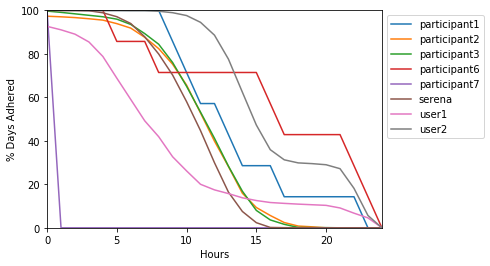

In [44]:
for i in range(len(adherence_nums)):
    plt.plot(adherence_nums[i], label = names[i])

plt.xlim((0,24))
plt.ylim((0,100))
plt.xlabel("Hours")
plt.ylabel("% Days Adhered")
plt.legend(bbox_to_anchor = (1,1), loc = "upper left")
plt.show()